# Table of contents
1. [Team members](#team)
2. [Libraries](#libraries)
3. [Exploring data](#exploring)
4. [Preprocessing data](#preprocessing)
5. [Questions](#questions)
    - [Question 1](#question-1)
    - [Question 2](#question-2)
    - [Question 3](#question-3)
    - [Question 4](#question-4)
    - [Question 5](#question-5)
6. [Modelling](#modelling)
    - [Data preparation](#modelling_preparation)
    - [Models: ](#models)
        - [Model 1 (change the number to the name of model. Ex: 1 -> Logistic Regression)](#model1)
    - [Evaluation](#evaluation)
7. [Reflection](#reflection)
    - [Difficulties during the project](#difficulties)
    - [Useful things learned](#useful)
    - [Plans to improve if have more time](#plans)
8. [References](#references)

<h1 id = "team">1. Team members</h1>
<style>
  table {
    margin: auto;
    width: 45%; /* Adjust the width as needed */
  }
  td {
    text-align: center;
    padding: 8px; /* Adding padding for better readability */
  }
  th
  {
    text-align: center;
  }
</style>

<table>
    <tr>
        <th> ID </th>
        <th> NAME </th>
    </tr>
    <tr>
        <td>22127148</td>
        <td>Dương Nhật Huy</td>
    </tr>
    <tr>
        <td>22127224</td>
        <td>Trương Thuận Kiệt</td>
    </tr>
    <tr>
        <td>22127257</td>
        <td>Phạm Minh Mẫn</td>
    </tr>
    <tr>
        <td>22127492</td>
        <td>Hồ Đăng Phúc</td>
    </tr>

<h1 id = "libraries"> 2. Libraries </h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
from scipy.stats import sem


In [2]:
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import ttest_ind

<h1 id = "exploring"> 3. Exploring data</h1>

In [3]:
raw_data  = pd.read_csv('./Data/full_data.csv')

In [4]:
raw_data.head()

,Title,CriticScore,UserScore,Link,PlatformReleased,Cast,Director,Genre,Rating,Runtime,Studio,Release Date,Production Budget,Domestic Gross,Worldwide Gross,Formated name,Metascore,Userscore
0,L.A. Confidential,99%,94%,https://www.rottentomatoes.com/m/la_confidential,Cinema,"Kevin Spacey, Russell Crowe, Guy Pearce, James...",Curtis Hanson,"Crime, Drama",R,2h 16m,Warner Home Vídeo,"Sep 19, 1997","$35,000,000","$64,604,977","$126,204,977",l.a.confidential,91,8.6
1,The Godfather,97%,98%,https://www.rottentomatoes.com/m/the_godfather,Cinema,"Marlon Brando, Al Pacino, James Caan, Richard ...",Francis Ford Coppola,"Crime, Drama",R,2h 57m,Paramount Pictures,"Mar 15, 1972","$7,000,000","$136,479,994","$270,007,394",thegodfather,100,9.3
2,Casablanca,99%,95%,https://www.rottentomatoes.com/m/1003707-casab...,Cinema,"Humphrey Bogart, Ingrid Bergman, Paul Henreid,...",Michael Curtiz,Drama,PG,1h 42m,Warner Bros. Pictures,"Jan 23, 1943","$1,039,000","$10,462,500","$10,567,179",casablanca,100,8.7
3,Parasite,99%,90%,https://www.rottentomatoes.com/m/parasite_2019,Cinema,"Song Kang-ho, Lee Sun-kyun, Jo Yeo-jeong, Choi...",Bong Joon Ho,"Comedy, Mystery & Thriller, Drama",R,2h 12m,Neon,"May 30, 2019","$11,800,000","$53,369,745","$253,267,858",parasite,97,8.9
4,Top Gun: Maverick,96%,99%,https://www.rottentomatoes.com/m/top_gun_maverick,Cinema,"Tom Cruise, Miles Teller, Jennifer Connelly, J...",Joseph Kosinski,"Action, Adventure",PG-13,2h 11m,Paramount Pictures,"May 20, 2022","$170,000,000","$718,732,821","$1,464,400,233",topgun:maverick,78,8.4


### Number of rows and columns

In [5]:
shape = raw_data.shape  
shape

(5106, 18)

### The meaning of each line

- Each line of the dataset is a record of a movie, and all records include various features of the movie like Name, Genres, Cast, Budget, Revenue, Runtime, etc

### Duplicated rows

In [6]:
num_duplicates = raw_data.duplicated().sum()
num_duplicates

np.int64(0)

Phew, luckily no duplicated rows

### The meaning of each column
- Title: The film title.
- CriticScore and UserScore: Percentage-based scores from critics and users, respectively.
- Link: URLs to movie pages.
- PlatformReleased: Indicates release platforms, such as Cinema.
- Cast and Director: Names of the main cast members and director.
- Genre, Rating, and Runtime: Film genre, content rating (e.g., PG, R), and runtime.
- Studio: The studio responsible for production or distribution.
- Release Date: Specific release date.
- Production Budget, Domestic Gross, and Worldwide Gross: Financial details in terms of budget and revenue.
- Metascore and Usescore: Average scores given by critics and users on Metacritic website.

### Data type of each column

In [7]:
dtype = raw_data.dtypes
dtype

Title                object
CriticScore          object
UserScore            object
Link                 object
PlatformReleased     object
Cast                 object
Director             object
Genre                object
Rating               object
Runtime              object
Studio               object
Release Date         object
Production Budget    object
Domestic Gross       object
Worldwide Gross      object
Formated name        object
Metascore            object
Userscore            object
dtype: object

As can be seen that, all types of each colum are currently objects. Therefore, those needs re-typing

### Data retyping

+ Title, Link, PlatformReleased, Studio : These are meant to be string, so there no need to convert it

+ CriticScore and UserScore are numbers, therfore we convert them into numerical datatype

Note : All numerical value are kept in float not interger because numpy require float to store nan

In [8]:
#Remove '%' notation and keep the score
def get_score_percentage(score_str):
    if pd.isna(score_str) or score_str == 'nan' or score_str == 'NaN':
        return np.nan
    elif re.match(r'^\d{1,3}%$', score_str):
            return float(score_str[:-1])
    return np.nan

raw_data['CriticScore'] = raw_data['CriticScore'].apply(get_score_percentage)
raw_data['UserScore'] = raw_data['UserScore'].apply(get_score_percentage)

+ Convert MetaScore and UserScore into Numerical datatype too

In [9]:
#Check if a string is a valid number because there are invalid value in Metascore and Userscore
def get_score(score_str):
    if pd.isna(score_str) or score_str == 'nan' or score_str == 'NaN':
        return np.nan
    elif re.match(r'^-?\d+(\.\d+)?$', score_str):
        return float(score_str)
    return np.nan
    
raw_data['Metascore'] = raw_data['Metascore'].apply(get_score)
raw_data['Userscore'] = raw_data['Userscore'].apply(get_score)


+ Because a movie may have many Actors, many Director and different Gern, we split them and store into a list

In [10]:
#Split string by comma seperated
def split_item(string):
    if pd.isna(string) or string == 'nan' or string == 'NaN':
        return pd.NA
    else:
        return string.split(', ')
    
raw_data['Cast'] = raw_data['Cast'].apply(split_item)
raw_data['Genre'] = raw_data['Genre'].apply(split_item)
raw_data['Director'] = raw_data['Director'].apply(split_item)

+ There are 10 different ratings, so we convert them into Pandas Categorial

In [11]:
raw_data['Rating'] = raw_data['Rating'].astype('category')

+ We convert Runtime into dictionary consists of hours and minutes for easier operating

In [12]:


# Collect runtime information and convert it into dictionary
def get_runtime(runtime_str):
    if pd.isna(runtime_str) or runtime_str == 'nan' or runtime_str == 'NaN':
        return pd.NA
    else:
        runtime = runtime_str.split()

        if 'h' in runtime[0]:   
            hours = int(runtime[0].split('h')[0])
            minutes = int(runtime[1].split('m')[0])
        else:
            hours = 0
            minutes = int(runtime[0].split('m')[0])
        return {'hours' : hours, 'minutes': minutes}

raw_data['Runtime'] = raw_data['Runtime'].apply(get_runtime)


+ We convert release date into Pandas Datetime

In [13]:
month_dict = {'Jan' : 1, 'Feb' : 2, 'Mar' : 3, 'Apr' : 4, 'May' : 5, 'Jun' : 6, 'Jul' : 7, 'Aug' : 8, 'Sep' : 9, 'Oct' : 10, 'Nov' : 11, 'Dec' : 12}

# Collect date string and store it into datetime format
def parse_datetime(date_str):
    if pd.isna(date_str) or date_str == 'nan' or date_str == 'NaN' or date_str == 'Unknown':
        return pd.NaT
    else:
        date = date_str.replace(',','').split()
        if len(date) == 1:
            year = int(date[0])
            return pd.to_datetime(year, format ='%Y')
        elif len(date) == 2:
            month = month_dict[date[0]]
            year = int(date[1])
            day = 1
            return pd.to_datetime(f'{year}-{month}-{day}', format='%Y-%m-%d')
        else:
            month = month_dict[date[0]]
            day = int(date[1])
            year = int(date[2])
            return pd.to_datetime(f'{year}-{month}-{day}', format='%Y-%m-%d')

raw_data['Release Date'] = raw_data['Release Date'].apply(parse_datetime)
    

+ Finally, convert Budgets and Grossess into numerical datatype and we are done

In [14]:
# Replace $ notation, replace comma and get the value
def parse_money(money_str):
    if pd.isna(money_str) or money_str == 'nan' or money_str == 'NaN':
        return np.nan
    else:
        money_str = money_str.replace('$','').replace(',','')
        return float(money_str)

raw_data['Production Budget'] = raw_data['Production Budget'].apply(parse_money)         
raw_data['Domestic Gross'] = raw_data['Domestic Gross'].apply(parse_money)
raw_data['Worldwide Gross'] = raw_data['Worldwide Gross'].apply(parse_money)

+ Rename UserScore, Userscrore columns and drop Formated name columns because we dont use it

In [15]:
raw_data.rename(columns={'UserScore' : 'Tomatoes UserScore', 'Userscore' : 'Meta UserScore', 'CriticScore' : 'Tomatoes CriticScore', 'MetaScore': 'Meta CriticScore'}, inplace=True)

raw_data = raw_data.drop('Formated name', axis=1)

In [16]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5106 entries, 0 to 5105
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Title                 5106 non-null   object        
 1   Tomatoes CriticScore  4129 non-null   float64       
 2   Tomatoes UserScore    4523 non-null   float64       
 3   Link                  5106 non-null   object        
 4   PlatformReleased      5106 non-null   object        
 5   Cast                  5074 non-null   object        
 6   Director              5071 non-null   object        
 7   Genre                 5060 non-null   object        
 8   Rating                4015 non-null   category      
 9   Runtime               5036 non-null   object        
 10  Studio                5059 non-null   object        
 11  Release Date          5031 non-null   datetime64[ns]
 12  Production Budget     5106 non-null   float64       
 13  Domestic Gross    

In [17]:
raw_data.head()

,Title,Tomatoes CriticScore,Tomatoes UserScore,Link,PlatformReleased,Cast,Director,Genre,Rating,Runtime,Studio,Release Date,Production Budget,Domestic Gross,Worldwide Gross,Metascore,Meta UserScore
0,L.A. Confidential,99.0,94.0,https://www.rottentomatoes.com/m/la_confidential,Cinema,"[Kevin Spacey, Russell Crowe, Guy Pearce, Jame...",[Curtis Hanson],"[Crime, Drama]",R,"{'hours': 2, 'minutes': 16}",Warner Home Vídeo,1997-09-19,35000000.0,64604977.0,1.262050e+08,91.0,8.6
1,The Godfather,97.0,98.0,https://www.rottentomatoes.com/m/the_godfather,Cinema,"[Marlon Brando, Al Pacino, James Caan, Richard...",[Francis Ford Coppola],"[Crime, Drama]",R,"{'hours': 2, 'minutes': 57}",Paramount Pictures,1972-03-15,7000000.0,136479994.0,2.700074e+08,100.0,9.3
2,Casablanca,99.0,95.0,https://www.rottentomatoes.com/m/1003707-casab...,Cinema,"[Humphrey Bogart, Ingrid Bergman, Paul Henreid...",[Michael Curtiz],[Drama],PG,"{'hours': 1, 'minutes': 42}",Warner Bros. Pictures,1943-01-23,1039000.0,10462500.0,1.056718e+07,100.0,8.7
3,Parasite,99.0,90.0,https://www.rottentomatoes.com/m/parasite_2019,Cinema,"[Song Kang-ho, Lee Sun-kyun, Jo Yeo-jeong, Cho...",[Bong Joon Ho],"[Comedy, Mystery & Thriller, Drama]",R,"{'hours': 2, 'minutes': 12}",Neon,2019-05-30,11800000.0,53369745.0,2.532679e+08,97.0,8.9
4,Top Gun: Maverick,96.0,99.0,https://www.rottentomatoes.com/m/top_gun_maverick,Cinema,"[Tom Cruise, Miles Teller, Jennifer Connelly, ...",[Joseph Kosinski],"[Action, Adventure]",PG-13,"{'hours': 2, 'minutes': 11}",Paramount Pictures,2022-05-20,170000000.0,718732821.0,1.464400e+09,78.0,8.4


### Numerical column exploration

For columns with numeric data types, calculate:
- Percentage of missing values (From this and further calculation to propose a suitable approach to fill missing values of that column)
- The min
- The lower quartile
- The median
- The upper quartile
- The max
After calculating, give **visualization** to help get deeper understanding of data, from that graph/chart give some comments on the values' distribution of that column

In [18]:
# TODO

### Categorical column exploration

For columns with non-numeric data types, you calculate:
- Percentage of missing values (From this and further calculation to propose a suitable approach to fill missing values of that column)
- Count no of unique values and no of element of each value (There is a column cast is quite difficult to explore, try to find a way)
-  Give **visualization** to help get deeper understanding of data, from that graph/chart or any collected information give some comments on the values' distribution of that column

<h4>Platform Released Column<h4>

- Distribution of values

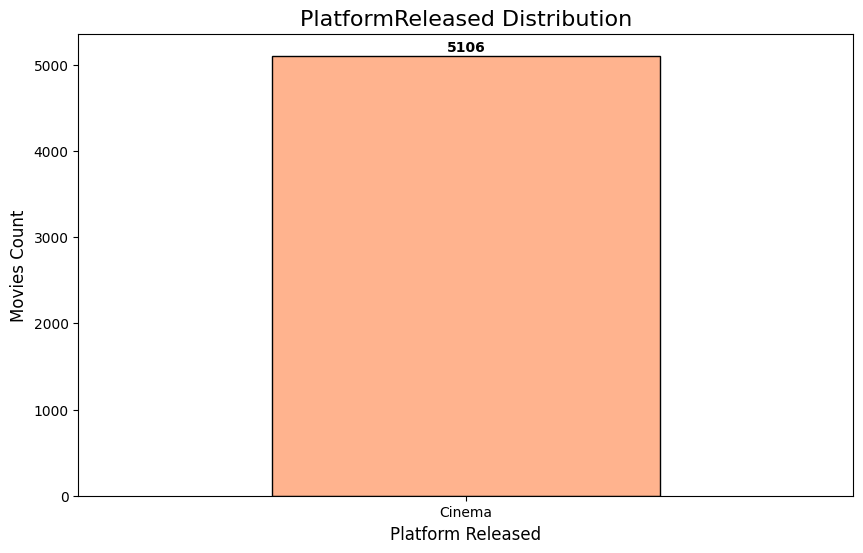

In [19]:
platform_count = raw_data['PlatformReleased'].value_counts()

plt.figure(figsize=(10, 6))
platform_count.plot(kind='bar', color='#FFB38E', edgecolor='black')

plt.title('PlatformReleased Distribution', fontsize=16)
plt.xlabel('Platform Released', fontsize=12)
plt.ylabel('Movies Count', fontsize=12)
plt.xticks(rotation=0)

for index, value in enumerate(platform_count):
    plt.text(index, value + 50, str(value), ha='center', fontsize=10, weight='bold')

plt.show()

- Percentage of missing values

In [20]:
print("Percentage of missing values in PlatformReleased: ", (raw_data['PlatformReleased'].isnull().sum() / len(raw_data)) * 100)

Percentage of missing values in PlatformReleased:  0.0


- Different values

In [21]:
print("Number of different PlatformReleased: ", len(raw_data['PlatformReleased'].unique()))
print("Different PlatformReleased: ", raw_data['PlatformReleased'].unique())

Number of different PlatformReleased:  1
Different PlatformReleased:  ['Cinema']



**Platform Release Analysis**

Key Findings

Column Redundancy

- **Uniform Value in PlatformReleased:** The "PlatformReleased" column contains only one unique value, **Cinema** across all entries. This shows that every movie in this dataset was exclusively released in theaters.
- **Lack of Differentiation:** Since the dataset only includes cinema releases, this column does not contribute additional insights.

---
Insights and Recommendations

- **Redundant Data:** The single-value nature of the "PlatformReleased" column indicates redundancy, as it does not provide any variability or segmentation within the data.
- **Recommendation for Data Preprocessing:** To optimize the dataset, consider removing the "PlatformReleased" column during preprocessing. Doing so can simplify the dataset structure and improve analysis efficiency.

---
Conclusion

This dataset's exclusive focus on cinema releases makes the "PlatformReleased" column unnecessary for analysis. Removing it can streamline the data and enhance processing efficiency without loss of information.

<h4>Cast Column<h4>

- Distribution of values

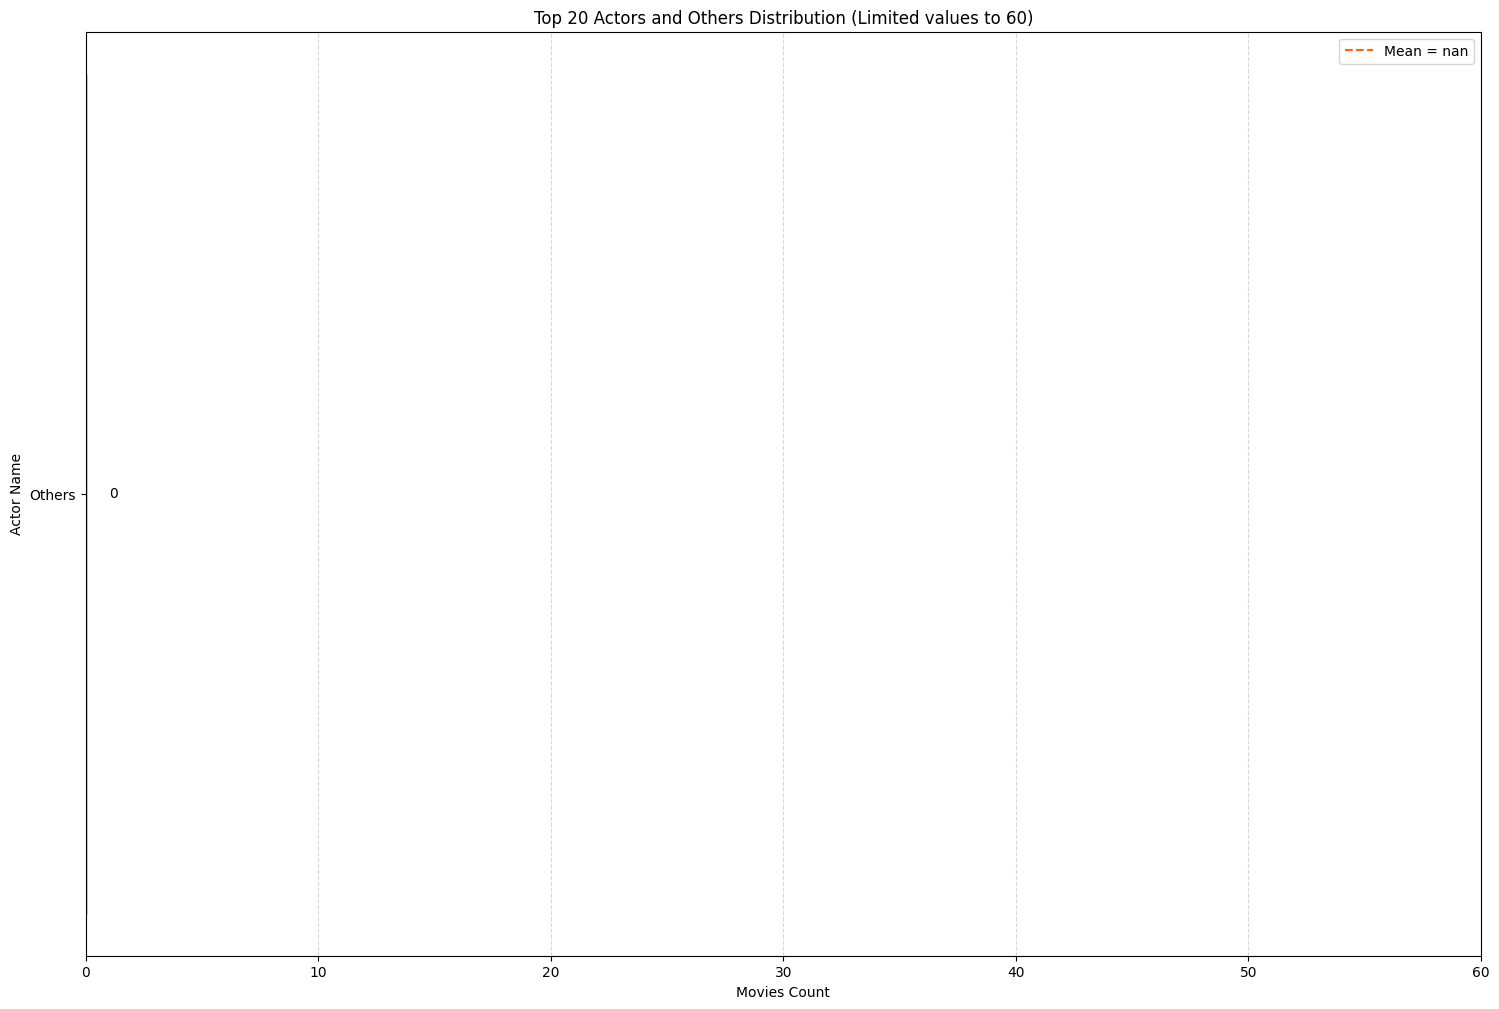

In [22]:
all_actors = raw_data['Cast'].str.split(', ').explode()
actors_count = all_actors.value_counts()
top_actors = actors_count.nlargest(20)
others_count = actors_count.iloc[20:].sum()
mean_count = actors_count.mean()

top_actors = pd.concat([top_actors, pd.Series({'Others': others_count})])

plt.figure(figsize=(18, 12))
bars = plt.barh(top_actors.index, top_actors.values, color='#9DBDFF', edgecolor='black')

lim = 60

for bar in bars:
    if bar.get_width() > lim:
        plt.text(lim + 1, bar.get_y() + bar.get_height()/2, 
                 f'{int(bar.get_width())}', va='center', color='red', fontsize=10, weight='bold')
    else: 
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                 f'{int(bar.get_width())}', va='center', color='black', fontsize=10)
        
plt.xlim(0, lim)

plt.axvline(mean_count, color='#FF6500', linestyle='--', linewidth=1.5, label=f'Mean = {mean_count:.1f}')

plt.xlabel('Movies Count')
plt.ylabel('Actor Name')
plt.title(f'Top 20 Actors and Others Distribution (Limited values to {lim})')
plt.gca().invert_yaxis() 
plt.grid(axis='x', linestyle='--', alpha=0.5) 
plt.legend()

plt.show()

- Percentage of missing values

In [23]:
print("Percentage of missing values in Cast: ", (raw_data['Cast'].isnull().sum() / len(raw_data)) * 100)

Percentage of missing values in Cast:  0.626713670191931


- Different values

In [24]:
print("Number of different Casts: ", len(actors_count))
print("Different Casts: ", actors_count.index.to_list())

Number of different Casts:  0
Different Casts:  []


**Cast Analysis** 

Key Findings

1. Actor Film Participation Distribution:

- **Top Actors' Participation:** Among the top 20 actors in the dataset, most have appeared in between 24 and 39 movies, with Samuel L. Jackson leading by participating in 47 films.
- **Average Participation:** On average, each actor has appeared in approximately 2.1 movies. While a few well-known actors have a high number of appearances, the majority have only one or two, reflecting a broad range of talent.
2. Data Diversity

- **Uneven Distribution of Appearances:** There is a notable disparity in film participation, with a few actors appearing in many films while most appear in significantly fewer. This imbalance suggests that a select group of actors dominates the dataset in terms of appearances.

3. Missing Data
- **Missing Percentage**: The "Cast" column has a missing value percentage of just 0.62%, indicating that cast information is largely complete and reliable for analysis
---
Insights and Recommendations

- **Skewed Participation:** The unequal distribution highlights a potential bias toward a small number of frequently cast actors, which may influence insights if not accounted for.
- **Segmentation for Deeper Insights:** To better understand trends, consider analyzing actors by segments (e.g., high, medium, and low participation levels). This could reveal patterns related to career longevity, genre focus, or popularity.
---
Conclusion

The dataset presents a valuable overview of cast diversity, with a skew toward a select group of highly active actors. Segmenting actors based on participation frequency could help uncover nuanced trends in actor roles and career trajectories.


Additional function to analyze categorical columns

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set theme
sns.set_theme(style="whitegrid")

data = raw_data.copy()

def general_column_analysis(df, column_name, split_values=True, delimiter=', '):
    # Percentage of missing values
    missing_percentage = df[column_name].isnull().mean() * 100
    
    if split_values:
        # Handle NaN values
        all_values = df[column_name].fillna('')
        
        # Split and count
        all_values = all_values.str.split(delimiter).explode()
        # Remove empty strings
        all_values = all_values[all_values != '']
        
        unique_values = all_values.value_counts()
        unique_count = unique_values.size
    else:
        # Original counting method for non-split columns
        unique_values = df[column_name].value_counts()
        unique_count = unique_values.size
    
    plt.figure(figsize=(12, 6))
    plot_data = unique_values.head(10)
    
    # Create horizontal bar plot
    plt.barh(y=range(len(plot_data)), width=plot_data.values, 
            color=sns.color_palette("viridis", 10))
    plt.yticks(range(len(plot_data)), plot_data.index)
    
    # Layout
    plt.title(f"Top 10 Most Common Values in '{column_name}'")
    plt.xlabel("Frequency")
    plt.ylabel(column_name)
    plt.tight_layout()
    plt.show()
    
    # top 10 genres and their counts
    print("\nTop 10 most common values:")
    print(unique_values.head(10).to_frame('Count'))

    return {
        "missing_percentage": f"{missing_percentage.round(3)}%",
        "unique_count": unique_count,
        "unique_values": unique_values
    }


<h4>Director Column<h4>

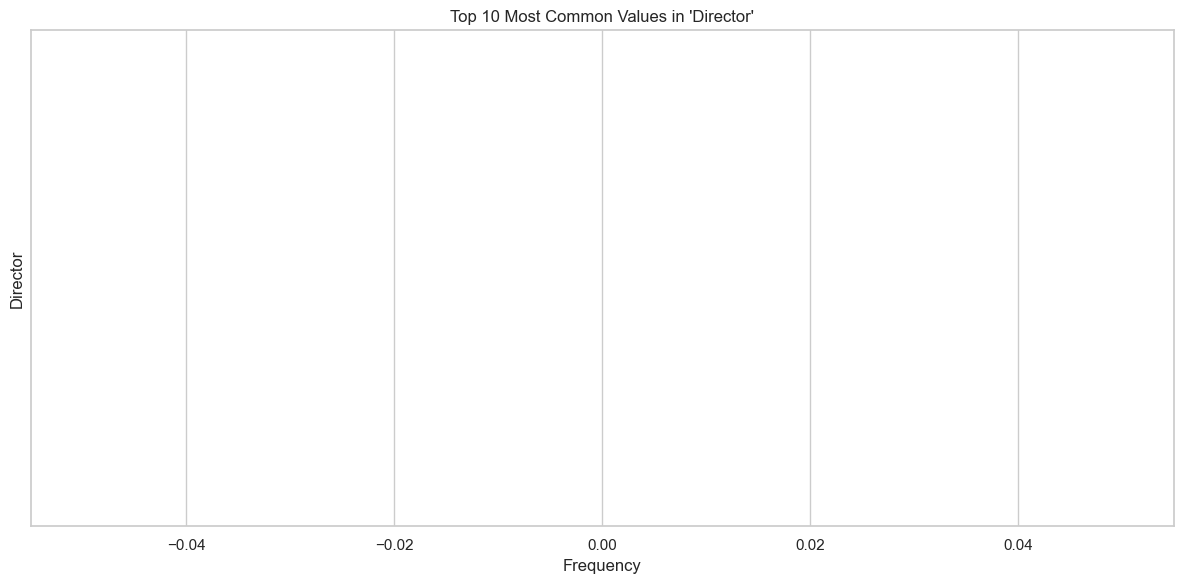


Top 10 most common values:
Empty DataFrame
Columns: [Count]
Index: []


{'missing_percentage': '0.685%',
 'unique_count': 0,
 'unique_values': Series([], Name: count, dtype: int64)}

In [26]:
director_analysis = general_column_analysis(data, 'Director')
director_analysis

#### Directors analysis

Key findings
 1. Top 10 Most Frequent Directors
The dataset reveals that a small group of directors has a significantly higher representation. Here are the top ten directors by count:

- **Steven Spielberg**: 23 entries
- **Clint Eastwood**: 21 entries
- **Woody Allen**: 20 entries
- **Ridley Scott**: 17 entries
- **Martin Scorsese**: 14 entries
- **Spike Lee**: 13 entries
- **Robert Rodriguez**: 12 entries
- **Ron Howard**: 11 entries
- **Renny Harlin**: 11 entries
- **Steven Soderbergh**: 11 entries

    These directors represent a significant portion of the dataset, suggesting either their prolific careers or a dataset emphasis on well-known or frequently analyzed directors.

 2. Data Diversity
- **Unique Count**: There are **3,013 unique directors** in the dataset, reflecting substantial diversity with many lesser-known or single-appearance directors.
- **Distribution**: While a few directors appear frequently, the majority appear only once, as seen in examples like T. Hee, Chinami Namba, Howard Hawks, Orson Welles, and Madoka Raine.

 3. Missing Data
- **Missing Percentage**: The dataset has a minimal missing percentage of **0.685%**. This low rate indicates good data quality, with nearly all director entries present.

---

 Insights and Recommendations

- **Data Skewness**: The distribution shows that while many unique directors are represented, a few prominent figures dominate the dataset. This skewness could influence analyses of director influence or trends, as findings may skew toward more popular directors.
- **Analysis of Underrepresented Directors**: Given the diversity of directors, further analysis could focus on examining trends among those with only one entry. This might uncover patterns in niche genres, regional cinema, or emerging directors.
- **Considerations for Comprehensive Analysis**: If the dataset is to be used for generalizing director trends, it might be beneficial to account for the dominance of high-frequency directors, perhaps by weighting entries or segmenting by frequency categories.

---

Conclusion

The dataset offers a valuable resource for analyzing directors, with strong representation from both high-profile directors and lesser-known names. The minimal missing data ensures reliability, and the diversity in director representation opens possibilities for both mainstream and niche analyses. Further examination may benefit from separating high-frequency and single-entry directors to gain insights across the spectrum.


<h4>Genre Column<h4>

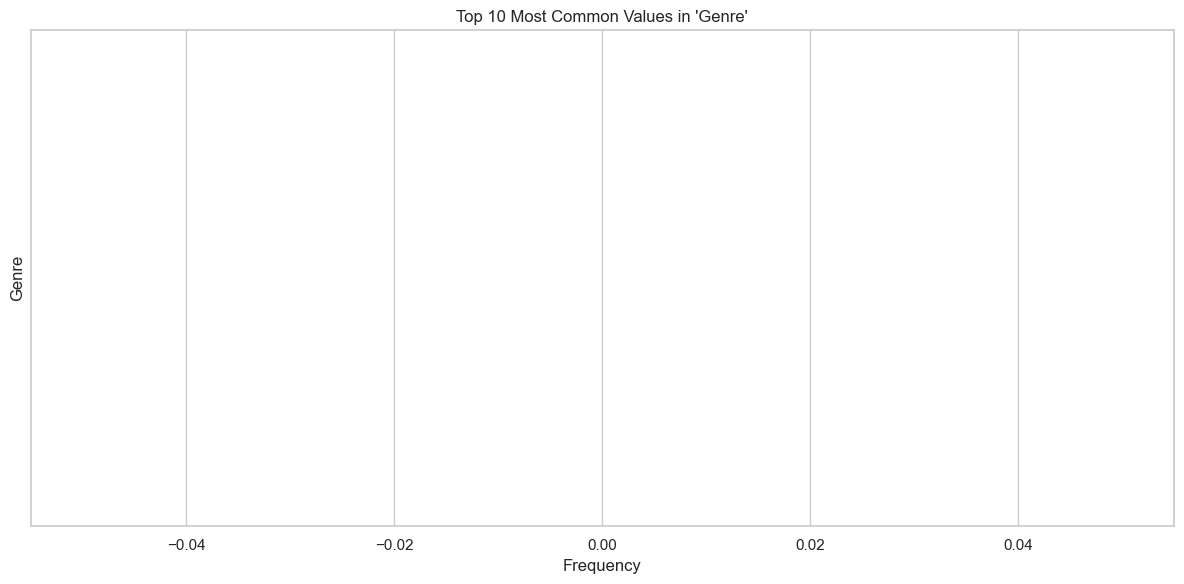


Top 10 most common values:
Empty DataFrame
Columns: [Count]
Index: []


{'missing_percentage': '0.901%',
 'unique_count': 0,
 'unique_values': Series([], Name: count, dtype: int64)}

In [27]:
genre_analysis = general_column_analysis(data, 'Genre')
genre_analysis   

#### Genre Analysis
 
 Key Findings
1. Top 10 Most Frequent Genres
The dataset shows a strong concentration in a few popular genres. Here are the top ten genres by frequency:

- **Drama**: 2,107 entries
- **Comedy**: 1,704 entries
- **Mystery & Thriller**: 968 entries
- **Action**: 890 entries
- **Adventure**: 759 entries
- **Horror**: 502 entries
- **Romance**: 457 entries
- **Fantasy**: 434 entries
- **Kids & Family**: 408 entries
- **Sci-Fi**: 395 entries

    These top genres make up a significant portion of the dataset, highlighting an emphasis on mainstream genres that appeal broadly to audiences.

 2. Data Diversity
- **Unique Count**: The dataset includes **26 unique genres**, suggesting a moderate level of diversity.
- **Distribution**: While certain genres are highly prevalent, others, such as *Foreign*, *Sports*, and *Faith & Spirituality*, have minimal representation (1 entry each). This distribution indicates that niche genres are underrepresented compared to popular categories like Drama and Comedy.

 3. Missing Data
- **Missing Percentage**: The dataset has a low missing percentage of **0.901%**, indicating that the genre data is largely complete and reliable.

---

 Insights and Recommendations

- **Data Skewness**: The dataset is skewed towards mainstream genres like Drama and Comedy, which could influence analyses on genre popularity or trends, favoring these popular genres over niche ones.
- **Analysis of Underrepresented Genres**: Niche genres with few entries, such as *Foreign* and *Sports*, might benefit from separate analysis. Examining these genres could uncover unique trends and appeal factors within less common categories.
- **Considerations for Generalization**: If the dataset is used for broad genre analysis, it's essential to account for the imbalance by potentially weighting genres or segmenting analyses to prevent dominant genres from overshadowing niche insights.

---

Conclusion

The dataset provides a valuable resource for genre analysis, with solid representation of mainstream genres and a lower presence of niche categories. The low missing data ensures data reliability, and the range of genres offers potential for both mainstream and niche analyses. For a comprehensive view, further segmentation by genre frequency could yield deeper insights into both widely enjoyed and specialized genres.


<h4>Rating Column<h4>

In [28]:
rating_analysis = general_column_analysis(data, 'Rating')
rating_analysis

TypeError: Cannot setitem on a Categorical with a new category (), set the categories first

#### Rating Analysis

Key Findings

1. Top 10 Most Frequent Ratings
The dataset shows a strong concentration of content rated for mature audiences. Here are the most frequent ratings by count:

- **R**: 1,886 entries
- **PG-13**: 1,282 entries
- **PG**: 680 entries
- **G**: 111 entries
- **TV-PG**: 19 entries
- **TV-14**: 14 entries
- **TV-MA**: 9 entries
- **TV-G**: 7 entries
- **NC-17**: 7 entries

    The predominance of *R* and *PG-13* ratings suggests the dataset leans towards content designed for older audiences.

2. Data Diversity
- **Unique Count**: There are **9 unique ratings** within the dataset, which covers a range of audience suitability from *G* to *NC-17*.
- **Distribution**: The bulk of entries are rated *R* and *PG-13*, while *TV* ratings (*TV-PG*, *TV-14*, *TV-MA*, *TV-G*) and *NC-17* are less represented. This distribution suggests an emphasis on theatrical releases or mature-themed content over family or TV-oriented programming.

3. Missing Data
- **Missing Percentage**: The dataset has a relatively high missing percentage of **21.367%** for ratings. This indicates that over a fifth of the entries lack rating information, potentially limiting the reliability of analyses focused on content suitability or audience targeting.

---

Insights and Recommendations

- **Data Skewness**: With *R* and *PG-13* accounting for the majority of entries, the dataset may not reflect a balanced view of family-friendly or universally suitable content.
- **Analysis of TV and Restricted Ratings**: The dataset includes a small portion of *TV* ratings (e.g., *TV-PG*, *TV-14*, *TV-MA*), suggesting limited representation of TV-exclusive content. If these ratings are of interest, supplementing the dataset with additional entries could provide a fuller picture of TV programming trends.
- **Addressing Missing Ratings**: The high missing percentage may impact analyses on content rating trends. To enhance accuracy, it is recommended to either impute missing ratings where possible or treat missing data separately to avoid skewed insights.

---

Conclusion

The dataset provides insights primarily into mature-rated and theatrically released content, with limited representation of family-friendly or TV-specific programming. The high missing data percentage suggests caution when interpreting rating distributions, as the absence of information may impact certain analyses. To create a more balanced dataset, additional entries in family and TV categories could be considered, alongside methods to address the missing ratings.


<h4>Studio Column<h4>

- Distribution of values

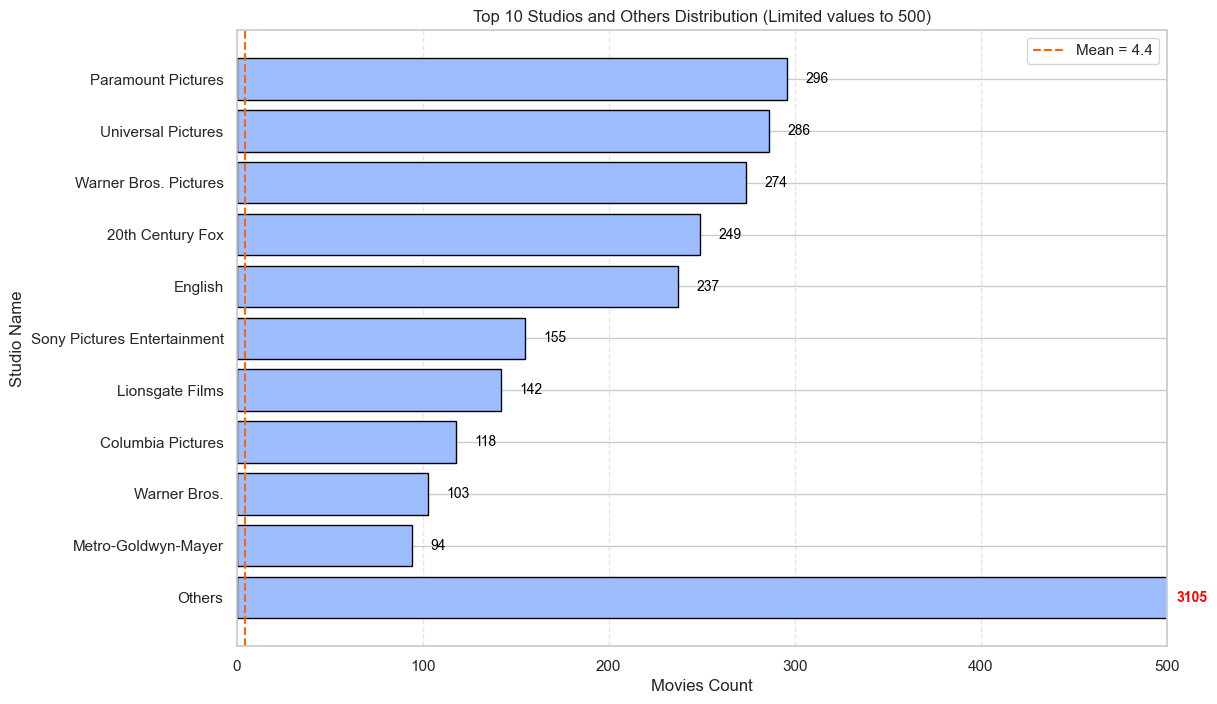

In [ ]:
top_studios = raw_data['Studio'].value_counts().nlargest(10)
others_count = raw_data['Studio'].value_counts().iloc[10:].sum()
top_studios = pd.concat([top_studios, pd.Series({'Others': others_count})])
mean_count = raw_data['Studio'].value_counts().mean()

plt.figure(figsize=(12, 8))
bars = plt.barh(top_studios.index, top_studios.values, color='#9DBDFF', edgecolor='black')

lim = 500

for bar in bars:
    if bar.get_width() > lim:
        plt.text(lim + 5, bar.get_y() + bar.get_height()/2, 
                 f'{int(bar.get_width())}', va='center', color='red', fontsize=10, weight='bold')
    else:
        plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2, 
                 f'{int(bar.get_width())}', va='center', color='black', fontsize=10)
        
plt.xlim(0, lim)

plt.axvline(mean_count, color='#FF6500', linestyle='--', linewidth=1.5, label=f'Mean = {mean_count:.1f}')

plt.xlabel('Movies Count')
plt.ylabel('Studio Name')
plt.title(f'Top 10 Studios and Others Distribution (Limited values to {lim})')
plt.gca().invert_yaxis() 
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.5) 

plt.show()

- Percentage of missing values

In [ ]:
print("Percentage of missing values in Studio: ", (raw_data['Studio'].isnull().sum() / len(raw_data)) * 100)

Percentage of missing values in Studio:  0.9204857030943987


- Different values

In [ ]:
print("Number of different Studios: ", len(raw_data['Studio'].unique()))
print("Different Studios: ", raw_data['Studio'].unique())

Number of different Studios:  1160
Different Studios:  ['Warner Home Vídeo' 'Paramount Pictures' 'Warner Bros. Pictures' ...
 'Pub CO 1' 'Pegasus Flying Films' 'Double R Productions']


**Studio Analysis**

Key Findings

1. Top 10 Film-Producing Studios: 

- **Paramount Pictures:** 296 entries
- **Universal Pictures:** 286 entries
- **Warner Bros. Pictures:** 274 entries
- **20th Century Fox:** 249 entries
- **English:** 237 entries (likely indicating a category error or label misinterpretation)
- **Sony Pictures Entertainment:** 155 entries
- **Lionsgate Films:** 142 entries
- **Columbia Pictures:** 118 entries
- **Warner Bros.:** 103 entries
- **Metro-Goldwyn-Mayer:** 94 entries
2. Data Diversity

- **Disparity Between Major and Minor Studios:** The difference in production volumes between the top studios and the overall average highlights a concentration of film production within a few major studios, suggesting that resources and distribution networks play a key role in the industry.

3. Missing Data
- **Missing Percentage**: The "Studio" column has a low missing data percentage of 0.92%, indicating that nearly all entries contain studio information. This high level of completeness supports reliable analysis based on studio-related insights.

---
Insights and Recommendations
- Studio Film Production Distribution: Among the top 10 film-producing studios, five have produced more than 200 movies, with production counts ranging from 237 to 296. The remaining five studios have produced fewer than 155 movies each.

- Average Film Production per Studio: On average, each studio in the dataset has produced about 4.4 movies. This highlights a significant dispersion in the film industry, where many smaller or independent studios produce fewer films, while larger studios account for the bulk of production.

- Disparity Between Major and Minor Studios: The gap between the production numbers of the top 10 studios and the overall average illustrates the dominance of a few major studios in the industry, which produce far more films than smaller studios.

- Recommendation for Further Analysis: This concentration of production in a few large studios suggests that financial resources and distribution networks play a crucial role in film production. It may be useful to further explore the impact of studio size and resources on film output, and consider adjusting for this disparity in any related analyses.
    
---
Conclusion

The dataset shows a strong concentration of production among top studios, with Paramount Pictures, Universal Pictures, and Warner Bros. Pictures leading. With a low percentage of missing data, the dataset is reliable for studio-based insights, though addressing any data mislabeling (like "English") is recommended for accuracy. Segmenting studios by production volume can further enrich insights into industry patterns.

<h1 id = "preprocessing"> 4. Preprocessing data </h1>

<h1 id = "questions"> 5. Questions </h1>

<h2 id = question-1>5.1. Question 1</h2> 

<h2 id = question-2>5.2. Question 2</h2> 

<h2 id = question-3>5.3. Question 3</h2> 

<h2 id = question-4>5.4. Question 4</h2> 

<h2 id = question-5>5.5. Question 5</h2> 

<h1 id = "modelling">6. Modelling</h1>

<h2 id = "modelling_preparation">6.1. Data preparation</h2> 

<h2 id = "models">6.2. Models</h2> 

<h2 id = "models">6.2. Models</h2> 

<h3 id = "model1">6.2.1 Model 1</h3> 

<h2 id = >

<h2 id = "evaluation">6.3. Evaluation</h2> 

<h1 id = "reflection">7. Reflection</h1> 

<h2 id = "difficulties">7.1. Difficulties during the project</h2> 

<h2 id = "useful">7.2. Useful things learned</h2> 

<h2 id = "plans">7.3. Plans to improve if have more time</h2> 

<h1 id = "references">8. References</h1> 